Here you will learn to submit your model to a machine learning competition in Python.  It's fun, and it will give you a way to see your progress as your skills keep improving.*

# Introduction
Machine learning competitions are a great way to improve your skills and measure your progress as a data scientist. If you are using data from a competition on Kaggle, you can easily submit it from your notebook.  Here's how you do it.

# Example
We're doing very minimal data set up here so we can focus on how to submit modeling results to competitions. Other tutorials will teach you how build great models. So the model in this example will be fairly simple. We'll start with the code to read data, select predictors, and fit a model.

In [18]:
# if not 'sklearn' in sys.modules.keys():
#    pip.main(['install', 'sklearn'])
# if not 'kaggle' in sys.modules.keys():
#    pip.main(['install', 'kaggle'])
# import random
# import sys

# import pip

# print("Random number with seed 2021")
# first call
# random.seed(2021)

## Imports

In [19]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Define Constants

In [20]:
DATA_PATH = "https://raw.githubusercontent.com/serivan/mldmlab/master/Kaggle/KAGGLE21/"
OUTPUT_PATH = "kaggle_submissions/"
RANDOM_STATE = 3993
TRAIN_SIZE = 0.8

## Define Utils

Here we define a function for preperaing a submission file

In [21]:
def generateSubmission(myModel, submissionFile, description):
    # Read the test data
    X_test = pd.read_csv(DATA_PATH + "test.csv")

    # Impute each test item, then predict
    X_test_imp = imp.transform(X_test)

    # Use the model to make predictions
    y_test_pred = myModel.predict(X_test_imp)
    # print(y_test_pred)

    # submission file
    my_submission = pd.DataFrame({"test_index": X_test.index, "target": y_test_pred})
    # you could use any filename. We choose submission here
    my_submission.to_csv(OUTPUT_PATH + submissionFile, index=False)

    # Submit authomatically; kaggle API authentication needed
    #!kaggle competitions submit -c mldm-classification-competition-2020 -f {submissionFile} -m '{description}'

## Load Data

In [22]:
# Read the data
train = pd.read_csv(DATA_PATH + "train.csv")
train.dtypes

Id                       int64
st_slope               float64
age                    float64
chest_pain_type        float64
cholesterol            float64
exercise_angina        float64
fasting_blood_sugar    float64
max_heart_rate         float64
oldpeak                float64
pulse                  float64
resting_bp_s           float64
resting_ecg            float64
sex                    float64
Synt                   float64
target                   int64
dtype: object

In [23]:
train.head()

,Id,st_slope,age,chest_pain_type,cholesterol,exercise_angina,fasting_blood_sugar,max_heart_rate,oldpeak,pulse,resting_bp_s,resting_ecg,sex,Synt,target
0,1000,2.0,60.0,4.0,207.0,1.0,0.0,131.0,2.355921,329.0,129.0,2.0,1.0,0.791547,1
1,1001,2.0,52.0,4.0,182.0,1.0,0.0,140.0,1.501970,347.0,129.0,0.0,0.0,0.751132,0
2,1002,1.0,48.0,4.0,224.0,0.0,0.0,186.0,-0.025627,462.0,122.0,2.0,1.0,0.269111,0
3,1003,2.0,60.0,3.0,320.0,1.0,1.0,122.0,1.654389,303.0,141.0,1.0,1.0,0.669550,1
4,1004,1.0,57.0,2.0,266.0,0.0,0.0,142.0,0.270579,351.0,123.0,0.0,1.0,0.533639,1


## Count missing values in columns

In [24]:
number_of_missing_in_cols = train.shape[0] - train.count()
number_of_missing_in_cols

Id                       0
st_slope                 1
age                      4
chest_pain_type         10
cholesterol            188
exercise_angina          3
fasting_blood_sugar      8
max_heart_rate           4
oldpeak                  7
pulse                    4
resting_bp_s             4
resting_ecg              3
sex                      9
Synt                     0
target                   0
dtype: int64

## Divide features by sematic type (binary, nominal, numerical)

In [25]:
# Count the number of unique values in dataframe
cols_unique_vals_count = train.drop(columns="target").nunique().sort_values()
cols_unique_vals_count

exercise_angina           2
fasting_blood_sugar       2
sex                       2
resting_ecg               3
st_slope                  4
chest_pain_type           4
age                      49
resting_bp_s             87
max_heart_rate          121
cholesterol             222
pulse                   259
oldpeak                 947
Id                     1152
Synt                   1152
dtype: int64

In [26]:
# If the column has only 2 unique values it is a binary col
BINARY_COLS = [col for col, val in cols_unique_vals_count.items() if val == 2]
BINARY_COLS

['exercise_angina', 'fasting_blood_sugar', 'sex']

In [27]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NOMINAL_NUNIQUE_THRESHOLD = 10
NOMINAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > 2 and val < NOMINAL_NUNIQUE_THRESHOLD
]
NOMINAL_COLS

['resting_ecg', 'st_slope', 'chest_pain_type']

In [28]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NUMERICAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > NOMINAL_NUNIQUE_THRESHOLD
]
NUMERICAL_COLS

['age',
 'resting_bp_s',
 'max_heart_rate',
 'cholesterol',
 'pulse',
 'oldpeak',
 'Id',
 'Synt']

In [29]:
# Create the categorical columns list as binary + nominal
CATEGORICAL_COLS = BINARY_COLS + NOMINAL_COLS
CATEGORICAL_COLS

['exercise_angina',
 'fasting_blood_sugar',
 'sex',
 'resting_ecg',
 'st_slope',
 'chest_pain_type']

## Feature engineering phase

In [30]:
# Split dataset in data and target label
X_train, y_train = train.drop(columns="target"), train.target

In [31]:
# Create categorical transformer (binary + nominal)
# Replace imputer
categorical_transformer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

In [32]:
# Create numeric transformer
# Impute missing values using the median value of each colum
numeric_transformer = SimpleImputer(missing_values=np.nan, strategy="median")

In [33]:
# Create the imputer of mixed type columns
# ATTENTION: the preprocessor can be used in a Pipeline for simplicity
imputer = ColumnTransformer(
    transformers=[
        ("impute_numeric", numeric_transformer, NUMERICAL_COLS),
        ("impute_categorical", categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=True,
)

In [34]:
# Fit the imputer
imp = imputer.fit(X_train)
# Impute our data
X_train_imp = imp.transform(X_train)

[ColumnTransformer]  (1 of 2) Processing impute_numeric, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing impute_categorical, total=   0.0s


In [35]:
# Column names after mixed imputation procedure
COLUMN_NAMES = NUMERICAL_COLS + CATEGORICAL_COLS
# Create a DataFrame from numpy array for visualization and simplicity
X_train_imp = pd.DataFrame(data=X_train_imp, columns=COLUMN_NAMES)
X_train_imp.head()

,age,resting_bp_s,max_heart_rate,cholesterol,pulse,oldpeak,Id,Synt,exercise_angina,fasting_blood_sugar,sex,resting_ecg,st_slope,chest_pain_type
0,60.0,129.0,131.0,207.0,329.0,2.355921,1000.0,0.791547,1.0,0.0,1.0,2.0,2.0,4.0
1,52.0,129.0,140.0,182.0,347.0,1.501970,1001.0,0.751132,1.0,0.0,0.0,0.0,2.0,4.0
2,48.0,122.0,186.0,224.0,462.0,-0.025627,1002.0,0.269111,0.0,0.0,1.0,2.0,1.0,4.0
3,60.0,141.0,122.0,320.0,303.0,1.654389,1003.0,0.669550,1.0,1.0,1.0,1.0,2.0,3.0
4,57.0,123.0,142.0,266.0,351.0,0.270579,1004.0,0.533639,0.0,0.0,1.0,0.0,1.0,2.0


## Training

### You can train directly on the training set

In [36]:
my_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
my_model.fit(X_train_imp, y_train)
my_model.score(X_train_imp, y_train)

1.0

In [37]:
my_model.feature_importances_

array([0.05012747, 0.07763511, 0.07688727, 0.05501853, 0.05253802,
       0.08290898, 0.04803979, 0.03772154, 0.02302526, 0.01276602,
       0.04143481, 0.01742472, 0.30817693, 0.11629555])

In [38]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    data=my_model.feature_importances_,
    index=X_train_imp.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
feature_importances

,importance
st_slope,0.308177
chest_pain_type,0.116296
oldpeak,0.082909
resting_bp_s,0.077635
max_heart_rate,0.076887
cholesterol,0.055019
pulse,0.052538
age,0.050127
Id,0.048040
sex,0.041435


In [39]:
y_pred = my_model.predict(X_train_imp)
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

print("Classification Report:")
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[649   0]
 [  0 503]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       649
           1       1.00      1.00      1.00       503

    accuracy                           1.00      1152
   macro avg       1.00      1.00      1.00      1152
weighted avg       1.00      1.00      1.00      1152



In [40]:
# generate a submission file
generateSubmission(my_model, "first_decision_tree.csv", "Default Decision Tree Model")

/home/iserina/.local/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### You can consider different models splitting in training and testing

In [41]:
X_train_imp_2, X_test_imp_2, y_train_2, y_test_2 = train_test_split(
    X_train_imp, y_train, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)

In [42]:
classification_tree = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
classification_tree.fit(X_train_imp_2, y_train_2)
classification_tree.score(X_train_imp_2, y_train_2)

0.8360477741585234

In [43]:
classification_tree.score(X_test_imp_2, y_test_2)

0.8138528138528138

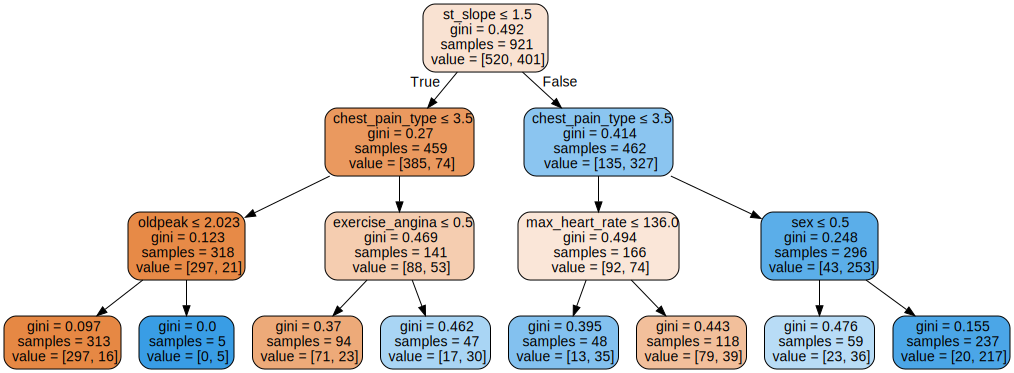

In [44]:
# Visualize Decision Tree
dot_data = export_graphviz(
    decision_tree=classification_tree,
    out_file="decision_tree_heart_desease.dot",
    feature_names=COLUMN_NAMES,
    filled=True,
    rounded=True,
    special_characters=True,
)

# Read the dot graph and display image
with open("decision_tree_heart_desease.dot") as f:
    dot_graph = f.read()

# display(graphviz.Source(dot_graph))
display(graphviz.Source(dot_graph))

In [45]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    classification_tree.feature_importances_,
    index=COLUMN_NAMES,
    columns=["importance"],
).sort_values("importance", ascending=False)
feature_importances

,importance
st_slope,0.597787
chest_pain_type,0.236084
max_heart_rate,0.047127
exercise_angina,0.042190
oldpeak,0.038509
sex,0.038302
age,0.000000
resting_bp_s,0.000000
cholesterol,0.000000
pulse,0.000000


In [46]:
y_pred_2 = classification_tree.predict(X_test_imp_2)
print("Confusion Matrix:")
print(confusion_matrix(y_test_2, y_pred_2))

print("Classification Report:")
print(classification_report(y_test_2, y_pred_2))

Confusion Matrix:
[[104  25]
 [ 18  84]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       129
           1       0.77      0.82      0.80       102

    accuracy                           0.81       231
   macro avg       0.81      0.81      0.81       231
weighted avg       0.82      0.81      0.81       231



In [47]:
classification_tree.fit(X_train_imp, y_train)
classification_tree.score(X_train_imp, y_train)

0.8324652777777778

In [48]:
# generate a submission file
generateSubmission(
    classification_tree,
    "second_decision_tree.csv",
    "User defined decision tree evaluated with test set",
)

/home/iserina/.local/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### Or you can consider different models using cross validation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Text(0.5, 1.0, 'Average score: 0.8332908545727136')

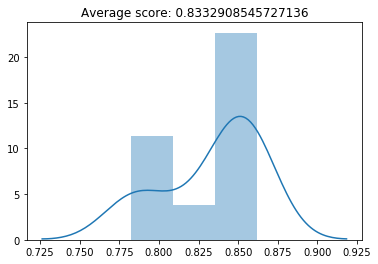

In [49]:
dtc = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    dtc, X_train_imp, y_train, cv=10, scoring="accuracy", verbose=1
)
sns.distplot(cv_scores)
plt.title("Average score: {}".format(np.mean(cv_scores)))

In [50]:
dtc.fit(X_train_imp, y_train)
dtc.score(X_train_imp, y_train)

0.8602430555555556

In [51]:
# generate a submission file
generateSubmission(
    dtc,
    "crossval_decision_tree.csv",
    "User defined decision tree evaluated with cross validation",
)

/home/iserina/.local/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### Parameter Tuning

In every classification technique, there are some parameters that can be tuned to optimize the classification. Some parameters that can be tuned in the decision tree is max depth (the depth of the tree), max feature (the feature used to classify), criterion, and splitter.

To search to tune parameter is to use Grid Search. Basically, it explores a range of parameters and finds the best combination of parameters. Then repeat the process several times until the best parameters are discovered. We will also use Stratified k-fold cross-validation that will prevent a certain class only split them to the same subset.

In [52]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
# Create the parameter grids
parameter_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [2, 3, 4, 5, 6, 7, 8],
    "max_features": ["sqrt", "log2", None],
}

# Create Stratified folds
cross_validation = StratifiedKFold(n_splits=10)
cross_validation.get_n_splits(X_train_imp, y_train)

# Create the scoring dictionary
SCORING = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1": "f1_macro",
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=parameter_grid,
    cv=cross_validation,
    verbose=1,
    scoring=SCORING,
    return_train_score=True,
    refit="accuracy",
)

grid_search.fit(X_train_imp, y_train)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:    6.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              pres...
                                              random_state=3993,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param

In [53]:
# grid_search.cv_results_

In [54]:
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.8558470764617692
Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3993, splitter='random')

In [55]:
my_model = best_dtc
my_model.fit(X_train_imp, y_train)
my_model.score(X_train_imp, y_train)

0.9166666666666666

In [56]:
y_pred = my_model.predict(X_train_imp)
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))

print("Classification Report:")
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[598  51]
 [ 45 458]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       649
           1       0.90      0.91      0.91       503

    accuracy                           0.92      1152
   macro avg       0.91      0.92      0.92      1152
weighted avg       0.92      0.92      0.92      1152



In [57]:
# The snippet below will retrieve the feature importances from the model and make them into a DataFrame.
feature_importances = pd.DataFrame(
    my_model.feature_importances_, index=COLUMN_NAMES, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importances

,importance
exercise_angina,0.321200
st_slope,0.193709
cholesterol,0.110138
sex,0.059223
chest_pain_type,0.058462
age,0.051467
resting_bp_s,0.046273
oldpeak,0.036759
fasting_blood_sugar,0.029661
pulse,0.026399


### Submit the final model

In [58]:
# generate a submission file
generateSubmission(
    my_model,
    "gridcv_decision_tree.csv",
    "User defined decision tree evaluated with grid search",
)

/home/iserina/.local/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Step by step commands...

In addition to your training data, there will be test data. This is frequently stored in a file with the title `test.csv`. This data won't include a column with your target (y), because that is what we'll have to predict and submit.  Here is sample code to do that. 

In [60]:
# Read the test data
X_test = pd.read_csv(DATA_PATH + "test.csv")

# Impute each test item, then predict
X_test_imp = imp.transform(X_test)

# Use the model to make predictions
y_test_pred = my_model.predict(X_test_imp)
print(y_test_pred)

[1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1
 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1
 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1
 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1
 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1]


/home/iserina/.local/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


# Prepare Submission File
We make submissions in CSV files.  Your submissions usually have two columns: an ID column and a prediction column.  The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the housing data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's `to_csv` method to write our submission file.  Explicitly include the argument `index=False` to prevent pandas from adding another column in our csv file.

In [61]:
# submission file
my_submission = pd.DataFrame({"test_index": X_test.index, "target": y_test_pred})
# you could use any filename. We choose submission here
my_submission.to_csv(OUTPUT_PATH + "submission.csv", index=False)

# Make Submission
Hit the blue **Publish** button at the top of your notebook screen.  It will take some time for your kernel to run.  When it has finished your navigation bar at the top of the screen will have a tab for **Output**.  This only shows up if you have written an output file (like we did in the **Prepare Submission File** step).  

Otherwise, if you have a kaggle API token (https://www.kaggle.com/docs/api#getting-started-installation-&-authentication), you can use the following command (remove the '#'):

In [62]:
# !kaggle competitions submit -c  heart-attack-analysis-and-prediction-21 -f kaggle_submissions/submission.csv -m "Please describe the technique used"


# Last Steps 
Click on the Output button.  This will bring you to a screen with an option to **Submit to Competition**.  Hit that and you will see how your model performed.

If you want to go back to improve your model, click the Edit button, which re-opens the kernel.  You'll need to re-run all the cells when you re-open the kernel.

# Conclusion
You've completed Level 1 of Machine Learning.  Congrats.  

If you are ready to keep improving your model (and your skills), start level 2 of [Learn Machine Learning](https://www.kaggle.com/learn/machine-learning). 

Level 2 covers more powerful models, techniques to include non-numeric data, and more.  You can make more submissions to the competition and climb up the leaderboard as you go through the course.


